# Version of DogFaceNet implementation for MNIST dataset
We will train to stick on the pairs learning technique

### Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import pickle
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tensorflow.keras.backend as K

### Dataset implementation

Load the dataset

In [2]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
SIZE = (28,28)
PATH_SAVE = '../output/history/'

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train /= 255
x_test /= 255

Create the pairs

In [ ]:
nbof_pairs = len(y_train)*2

pairs = np.empty((nbof_pairs,28,28))
issame = np.empty(nbof_pairs)

for i in tqdm_notebook(range(0,nbof_pairs,2)):
    alea = np.random.rand()
    # Pair of different dogs
    if alea < 0.5:
        # Chose the classes:
        class1 = np.random.randint(10)
        class2 = np.random.randint(10)
        while class1==class2:
            class2 = np.random.randint(10)
            
        # Extract images of this class:
        y_class1 = np.arange(len(y_train))[np.equal(y_train,class1)]
        y_class2 = np.arange(len(y_train))[np.equal(y_train,class2)]
        
        # Chose an image amoung these selected images
        pairs[i] = x_train[y_class1[np.random.randint(len(y_class1))]]
        pairs[i+1] = x_train[y_class2[np.random.randint(len(y_class2))]]
        issame[i] = issame[i+1] = 0
    # Pair of same dogs
    else:
        # Chose a class
        clas = np.random.randint(10)
        y_class = np.arange(len(y_train))[np.equal(y_train,clas)]
        
        # Select two images from this class
        idx_image1 = y_class[np.random.randint(len(y_class))]
        idx_image2 = y_class[np.random.randint(len(y_class))]
        while idx_image1 == idx_image2:
            idx_image2 = y_class[np.random.randint(len(y_class))]
        
        pairs[i] = x_train[idx_image1]
        pairs[i+1] = x_train[idx_image2]
        issame[i] = issame[i+1] = 1


In [3]:
# check some pairs
s = 20
n = 5
print(issame[2*s:(n+s)*2])
#print(y_pairs[2*s:(n+s)*2])
fig = plt.figure(figsize=(5,3*n))
for i in range(s,s+n):
    plt.subplot(n,2,2*(i-s)+1)
    plt.imshow(pairs[2*i])
    plt.subplot(n,2,2*(i-s)+2)
    plt.imshow(pairs[2*i+1])

NameError: name 'issame' is not defined

Create the triplets

In [3]:
nbof_triplets = len(y_train)

triplets = np.empty((nbof_triplets,28,28))
y_triplets = np.empty(nbof_triplets)
issame = np.empty(nbof_triplets)

for i in tqdm_notebook(range(0,nbof_triplets,3)):
    # Pair of same classes
    # Chose a class
    clas = np.random.randint(10)
    y_class = np.arange(len(y_train))[np.equal(y_train,clas)]

    # Select two images from this class
    idx_image1 = y_class[np.random.randint(len(y_class))]
    idx_image2 = y_class[np.random.randint(len(y_class))]
    while idx_image1 == idx_image2:
        idx_image2 = y_class[np.random.randint(len(y_class))]

    triplets[i] = x_train[idx_image1]
    triplets[i+1] = x_train[idx_image2]
    issame[i] = issame[i+1] = 1
    y_triplets[i] = y_triplets[i+1] = clas

    # Pair of different classes
    # Chose the classes:
    class2 = np.random.randint(10)
    while clas==class2:
        class2 = np.random.randint(10)

    # Extract images of this class:
    y_class2 = np.arange(len(y_train))[np.equal(y_train,class2)]

    # Chose an image amoung these selected images
    triplets[i+2] = x_train[y_class2[np.random.randint(len(y_class2))]]
    issame[i+2] = 0
    y_triplets[i+2] = class2

triplets_exp = np.expand_dims(triplets, -1)
triplets_exp.shape

HBox(children=(IntProgress(value=0, max=20000), HTML(value='')))

[1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0.]
[9. 9. 2. 4. 4. 1. 9. 9. 0. 8. 8. 7. 5. 5. 6.]


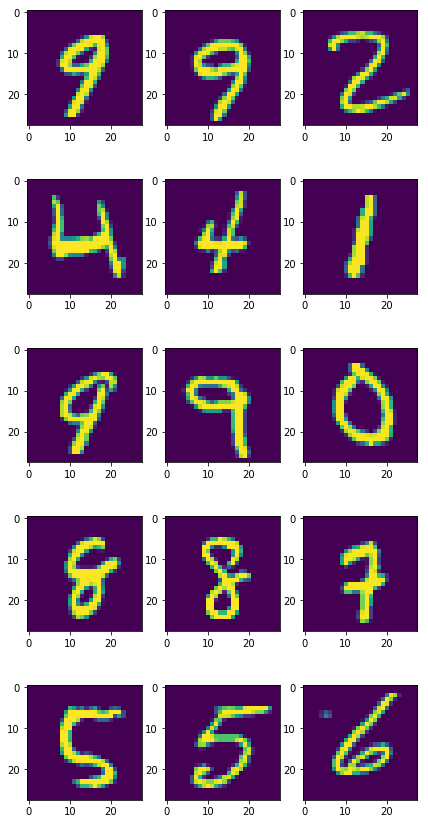

In [4]:
# Check some triplets
s = 10
n = 5
print(issame[3*s:(n+s)*3])
print(y_triplets[3*s:(n+s)*3])
fig = plt.figure(figsize=(7,3*n))
for i in range(s,s+n):
    plt.subplot(n,3,3*(i-s)+1)
    plt.imshow(triplets[3*i])
    plt.subplot(n,3,3*(i-s)+2)
    plt.imshow(triplets[3*i+1])
    plt.subplot(n,3,3*(i-s)+3)
    plt.imshow(triplets[3*i+2])

### Define the loss

In [6]:
import tensorflow.keras.backend as K
alpha = 0.3
def triplet(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p), axis = -1)
    an = K.sum(K.square(a-n), axis = -1)
    s = K.sum(tf.nn.relu(ap - an + alpha))
    return s

In [10]:
import tensorflow.keras.backend as K
alpha = 0.3
def cosine(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    cos_ap = K.sum(a*p, axis = -1)
    cos_an = K.sum(a*n, axis = -1)
    s = K.sum(tf.nn.relu(cos_ap - cos_an + alpha))
    return K.sum(s)

In [47]:
c = np.vstack([0,2,1,2])
np.hstack([c,c])

array([[0, 0],
       [2, 2],
       [1, 1],
       [2, 2]])

[[ 0.4472136   0.8944272 ]
 [ 0.78086877  0.62469506]
 [-0.8944272   0.4472136 ]
 [ 0.31622776  0.94868326]]
[array([[1., 0., 0., 0.],
       [0., 1., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 1.]], dtype=float32), array([[1.        , 0.9539797 , 0.5       , 0.99497473],
       [0.9539797 , 1.        , 0.29047096, 0.9197851 ],
       [0.5       , 0.29047096, 1.        , 0.57071066],
       [0.99497473, 0.9197851 , 0.57071066, 1.        ]], dtype=float32), array([[1.1920933e-07, 3.0786719e+00, 6.9314718e-01, 5.2932763e+00],
       [3.0786719e+00, 1.1920933e-07, 3.4315383e-01, 8.3615243e-02],
       [6.9314718e-01, 3.4315383e-01, 1.1920933e-07, 8.4562409e-01],
       [5.2932763e+00, 8.3615243e-02, 8.4562409e-01, 1.1920933e-07]],
      dtype=float32)]


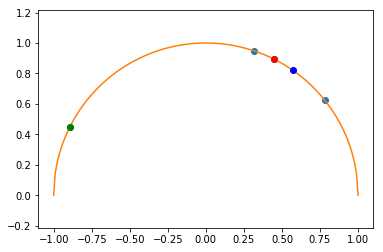

In [23]:
# Exploration with numpy
# In dev: bobby loss
_y_pred = np.array([[-0.25,1],[5,4],[-1,.5],[1,3.]], dtype=np.float32)
_y_pred = np.array([[1,2],[5,4],[-1,.5],[1,3.]], dtype=np.float32)
#_y_pred = np.array([[1,2],[5,4],[-1,.5],[1,3.],[-1,0.1]], dtype=np.float32)
_y_true = [0,2,1,2]
_y_pred_norm = _y_pred/np.linalg.norm(_y_pred, axis=-1, keepdims=True)

print(_y_pred_norm)
plt.plot(_y_pred_norm[:,0],_y_pred_norm[:,1],'o')

_classes = tf.keras.utils.to_categorical(_y_true,3)
_centers = np.transpose(_y_pred_norm.T.dot(_classes / (np.sum(_classes, axis=0, keepdims=True)+1)))
_centers_norm = _centers/np.linalg.norm(_centers, axis=-1, keepdims=True)
x = np.linspace(-1,1,200)
plt.axis('equal')
plt.plot(x,np.sqrt(1.-np.square(x)))
colors = ['r','g','b']
for i in range(3):
    plt.plot(_centers_norm[i,0],_centers_norm[i,1],colors[i]+'o')

    
# Exploration with tensorflow
y_pred = tf.constant(_y_pred)
c = np.vstack(_y_true)
y = np.hstack([c,c])
y_true = tf.constant(y)

y_pred = y_pred / tf.norm(y_pred, axis=-1, keepdims=True)

extract = tf.cast(y_true[:,0], dtype=tf.int32)
classes = tf.one_hot(extract,depth=3)
classes = tf.cast(classes, dtype=tf.float32)

# Simulation into the loss function:
dot_y_pred = K.dot(y_pred,K.transpose(y_pred))
is_same_mask = K.dot(classes,K.transpose(classes))

out = K.binary_crossentropy(is_same_mask,dot_y_pred*0.5+0.5)

with tf.Session() as sess:
    print(sess.run([is_same_mask,dot_y_pred*0.5+0.5,out]))

c:\users\guillaume\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


[array([[2., 4., 1.]], dtype=float32), array([-2.5000005 , -0.99753946,  0.72142017, -2.377534  ], dtype=float32), array([0.07585815, 0.26942548, 0.67291963, 0.08490197], dtype=float32), 1.1031052, 1.4880667]


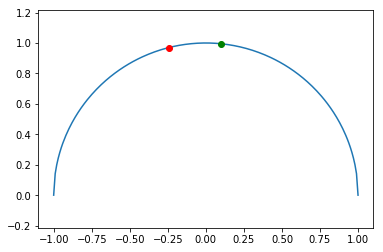

In [18]:
# Exploration with numpy
# In dev: robert loss
_y_pred = np.array([[-0.25,1],[5,4],[-1,.5],[1,3.]], dtype=np.float32)
#_y_pred = np.array([[1,2],[5,4],[-1,.5],[1,3.]], dtype=np.float32)
#_y_pred = np.array([[1,2],[5,4],[-1,.5],[1,3.],[-1,0.1]], dtype=np.float32)
_y_true = [0,1,1,1]
_y_pred_norm = _y_pred/np.linalg.norm(_y_pred, axis=-1, keepdims=True)
_classes = tf.keras.utils.to_categorical(_y_true,3)
_centers = np.transpose(_y_pred_norm.T.dot(_classes / np.sum(_classes, axis=0, keepdims=True)))
_centers_norm = _centers/np.linalg.norm(_centers, axis=-1, keepdims=True)
x = np.linspace(-1,1,200)
plt.axis('equal')
plt.plot(x,np.sqrt(1.-np.square(x)))
colors = ['r','g','b']
for i in range(3):
    plt.plot(_centers_norm[i,0],_centers_norm[i,1],colors[i]+'o')
#plt.plot(_y_pred[:,0], _y_pred[:,1], 'go')

# Exploration with tensorflow
y_pred = tf.constant(_y_pred)
c = np.vstack(_y_true)
y = np.hstack([c,c])
y_true = tf.constant(y)


# Simulation into the loss function:
pred = y_pred / tf.norm(y_pred, axis=-1, keepdims=True)

extract = tf.cast(y_true[:,0], dtype=tf.int32)
classes = tf.one_hot(extract,depth=3)
classes = tf.cast(classes, dtype=tf.float32)
den_classes = K.sum(classes, axis=0, keepdims=True) + 1.
centers = K.transpose(K.dot(K.transpose(pred), classes / den_classes))
centers = tf.math.l2_normalize(centers,axis=-1)
centers_classes = K.dot(classes, centers)
ones = (K.sum(centers_classes * pred, axis=-1) * -1. + .5)*5
inter = K.sigmoid(ones)
dist = K.sum(inter)

identity = K.arange(0,3)
identity = tf.one_hot(identity,3)

gram = K.dot(centers,K.transpose(centers)) * 0.5 + 0.5
dev = K.sum(K.pow(gram-identity,10))
with tf.Session() as sess:
    print(sess.run([den_classes,ones,inter,dist,dev]))

In [23]:
# Test on cosine loss
_y_pred = np.array([[-0.25,2,1],[5,4,2],[-1,.5,2],[2,1,3.]], dtype=np.float32)
_y_pred = _y_pred / np.linalg.norm(_y_pred, axis=-1, keepdims=True)
y_pred = tf.constant(_y_pred)

_y_true = tf.keras.utils.to_categorical([0,1,2,1])
y_true = tf.constant(_y_true)


s = 1.
m = 0.08

exp_s = K.exp(s * y_pred)
exp_s_m = K.exp(s * (y_pred - m))

masked_exp_s_m = exp_s_m * y_true

inv_mask = 1. - y_true
masked_exp_s = exp_s * inv_mask

den = K.sum(masked_exp_s + masked_exp_s_m, axis=-1, keepdims=True)
out = masked_exp_s_m / den
out = K.sum(out,axis=-1)
log_out = - K.log(out)
ret = K.sum(log_out)

with tf.Session() as sess:
    print(sess.run([out,log_out,ret]))

[array([0.17144571, 0.32664338, 0.53896874, 0.23452379], dtype=float32), array([1.7634887, 1.1188862, 0.6180977, 1.4501983], dtype=float32), 4.9506707]


In [91]:
# Test on arccosine loss
_y_pred = np.array([[-0.25,2,1],[5,4,2],[-1,.5,2],[2,1,3.]], dtype=np.float32)
_y_pred = _y_pred / np.linalg.norm(_y_pred, axis=-1, keepdims=True)
y_pred = tf.constant(_y_pred)

_y_true = tf.keras.utils.to_categorical([0,1,2,1])
y_true = tf.constant(_y_true)


s = 1.
m = 0.08

exp_s = K.exp(s * y_pred)

cos = y_pred
sin = K.sqrt(1. - K.square(cos))
cos_m = K.cos(m)
sin_m = K.sin(m)
cos_t_m = cos * cos_m - sin * sin_m

exp_s_m = K.exp(s * cos_t_m)

masked_exp_s_m = exp_s_m * y_true

inv_mask = 1. - y_true
masked_exp_s = exp_s * inv_mask

den = K.sum(masked_exp_s + masked_exp_s_m, axis=-1, keepdims=True)
out = masked_exp_s_m / den
out = K.sum(out,axis=-1)
log_out = - K.log(out)
ret = K.sum(log_out)

with tf.Session() as sess:
    print(sess.run([y_pred,cos_t_m,out,log_out,ret]))

[array([[-0.11111111,  0.8888889 ,  0.44444445],
       [ 0.745356  ,  0.5962848 ,  0.2981424 ],
       [-0.43643576,  0.21821788,  0.8728715 ],
       [ 0.5345225 ,  0.26726124,  0.8017837 ]], dtype=float32), array([[-0.19017561,  0.84943527,  0.3714349 ],
       [ 0.6896957 ,  0.5302244 ,  0.2209086 ],
       [-0.506942  ,  0.1395312 ,  0.83108544],
       [ 0.46527272,  0.18939877,  0.7514612 ]], dtype=float32), array([0.17157863, 0.3297167 , 0.5484489 , 0.23490773], dtype=float32), array([1.7627137 , 1.1095214 , 0.60066116, 1.4485625 ], dtype=float32), 4.9214587]


In [25]:
import tensorflow.keras.backend as K

def robert(y_true,y_pred):
    """
    Robert tries to increase the angle between the centers
    of each classes (=increase the deviation of the centers)
    and to decrease the angle between elements of a certain class
    (=decrease the deviation of the elements of a class).
    """
    extract = tf.cast(y_true[:,0], dtype=tf.int32)
    classes = tf.one_hot(extract,depth=10)
    classes = tf.cast(classes, dtype=tf.float32)
    
    centers = K.transpose(K.dot(K.transpose(y_pred), classes / (K.sum(classes, axis=0, keepdims=True) + 1)))
    centers = tf.math.l2_normalize(centers,axis=-1)
    centers_classes = K.dot(classes, centers)
    
    # "dist" computes the angle
    dist = (K.sum(centers_classes * y_pred, axis=-1) * -1. + .5)*5
    dist = K.sum(K.sigmoid(dist))

    identity = K.arange(0,10)
    identity = tf.one_hot(identity,10)
    
    gram = K.dot(centers,K.transpose(centers)) * 0.5 + 0.5
    dev = K.sum(K.pow(gram-identity,10))
    return dev + dist

In [15]:
def bobby(y_true,y_pred):
    extract = tf.cast(y_true[:,0], dtype=tf.int32)
    classes = tf.one_hot(extract,depth=10)
    classes = tf.cast(classes, dtype=tf.float32)
    
    dot_y_pred = K.dot(y_pred,K.transpose(y_pred))
    is_same_mask = K.dot(classes,K.transpose(classes))

    return K.binary_crossentropy(is_same_mask,dot_y_pred*0.5+0.5)

In [70]:
s = 30.
m = 0.1
def cosine(y_true,y_pred):
    
    exp_s = K.exp(s * y_pred)
    exp_s_m = K.exp(s * (y_pred - m))
    
    masked_exp_s_m = exp_s_m * y_true
    
    inv_mask = 1. - y_true
    masked_exp_s = exp_s * inv_mask
    
    den = K.sum(masked_exp_s + masked_exp_s_m, axis=-1, keepdims=True)
    out = masked_exp_s_m / den
    out = K.sum(out,axis=-1)
    ret = - K.log(out)
    ret = K.sum(ret)
    return ret

In [97]:
# This loss doesnt work yet...

s = 10.
m = 0.1
def arccosine(y_true,y_pred):
    
    exp_s = K.exp(s * y_pred)
    
    cos = y_pred
    sin = K.sqrt(1. - K.square(cos))
    cos_m = K.cos(m)
    sin_m = K.sin(m)
    cos_t_m = cos * cos_m - sin * sin_m
    
    std_cos_t_m = y_pred - m
    
    # check if theta is less than pi-m:
    keep = K.cast(K.less(cos, K.cos(np.pi - m)),K.floatx())
    not_keep = 1 - keep
    cos_t_m = cos_t_m * keep + std_cos_t_m * not_keep
    
    exp_s_m = K.exp(s * cos_t_m)
    
    masked_exp_s_m = exp_s_m * y_true
    
    inv_mask = 1. - y_true
    masked_exp_s = exp_s * inv_mask
    
    den = K.sum(masked_exp_s + masked_exp_s_m, axis=-1, keepdims=True)
    out = masked_exp_s_m / den
    out = K.sum(out,axis=-1)
    ret = - K.log(out)
    ret = K.sum(ret)
    return ret

### Define the network

In [5]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

class Cosine(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Cosine, self).__init__(**kwargs)

    def build(self, input_shape):
        shape = tf.TensorShape((input_shape[-1],self.output_dim))

        self.kernel = self.add_weight(name='kernel', 
                                      shape=shape,
                                      initializer='uniform',
                                      trainable=True)
        super(Cosine, self).build(input_shape)

    def call(self, x):
        x = tf.math.l2_normalize(x, axis=-1)
        w = tf.math.l2_normalize(self.kernel, axis=0)
        
        return K.dot(x, w)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [98]:
# Small net and cosine loss
emb_size = 3

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Cosine(10))

model.compile(loss=cosine,
              optimizer='rmsprop',
              metrics=['accuracy']
             )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
__________

In [16]:
# Small net and bobby loss
emb_size = 3

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Lambda(lambda x: tf.math.l2_normalize(x, axis=-1)))

model.compile(loss=bobby,
              optimizer='rmsprop'
             )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

In [68]:
# Small net and softmax loss

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Lambda(lambda x: tf.math.l2_normalize(x, axis=-1)))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy']
             )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
__________

In [7]:
x_test.shape

(10000, 28, 28)

In [8]:
x_test = np.expand_dims(x_test,-1)
x_train = np.expand_dims(x_train,-1)

In [9]:
y_train_exp = tf.keras.utils.to_categorical(y_train)
y_test_exp = tf.keras.utils.to_categorical(y_test)

In [10]:
hist = model.fit(x_train,np.dstack([y_train]*2)[0], batch_size=128,epochs=25,validation_data=(x_test,np.dstack([y_test]*2)[0]))

ValueError: Error when checking target: expected cosine to have shape (10,) but got array with shape (2,)

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
history = np.array([loss,val_loss])
np.save(PATH_SAVE+'2018.01.31.small_net.bobby.2.npy',history)
np.savetxt(PATH_SAVE+'2018.01.31.small_net.bobby.2.txt',history)

epochs = np.arange(len(loss))
plt.plot(epochs,loss, label="loss")
plt.plot(epochs,val_loss, label="val_loss")
plt.xlabel("Number of epochs")
plt.legend()

In [99]:
history = model.fit(x_train,y_train_exp, batch_size=128,epochs=12,validation_data=(x_test,y_test_exp))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
20864/60000 [=========>....................] - ETA: 14:51 - loss: 1551.1194 - acc: 0.101 - ETA: 5:05 - loss: nan - acc: 0.0964      - ETA: 3:07 - loss: nan - acc: 0.09 - ETA: 2:17 - loss: nan - acc: 0.10 - ETA: 1:49 - loss: nan - acc: 0.10 - ETA: 1:31 - loss: nan - acc: 0.10 - ETA: 1:19 - loss: nan - acc: 0.09 - ETA: 1:10 - loss: nan - acc: 0.09 - ETA: 1:03 - loss: nan - acc: 0.09 - ETA: 57s - loss: nan - acc: 0.0983 - ETA: 53s - loss: nan - acc: 0.099 - ETA: 49s - loss: nan - acc: 0.097 - ETA: 46s - loss: nan - acc: 0.096 - ETA: 43s - loss: nan - acc: 0.096 - ETA: 41s - loss: nan - acc: 0.099 - ETA: 39s - loss: nan - acc: 0.098 - ETA: 37s - loss: nan - acc: 0.096 - ETA: 36s - loss: nan - acc: 0.096 - ETA: 34s - loss: nan - acc: 0.095 - ETA: 33s - loss: nan - acc: 0.096 - ETA: 32s - loss: nan - acc: 0.098 - ETA: 31s - loss: nan - acc: 0.098 - ETA: 30s - loss: nan - acc: 0.098 - ETA: 29s - loss: nan - acc: 0.097 - ETA: 28s - l

KeyboardInterrupt: 

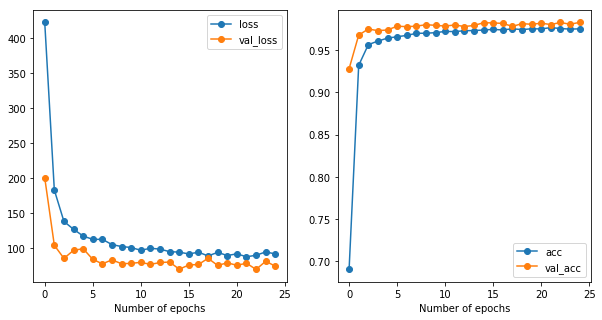

In [73]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.01.31.small_net.cosine.s_30.m_0.1.npy',history_)
np.savetxt(PATH_SAVE+'2018.01.31.small_net.cosine.s_30.m_0.1.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.legend()

### Train the model

In [24]:
model.compile(loss=triplet,
              optimizer='rmsprop')

In [12]:
model.fit(
    triplets_exp,
    np.zeros((len(triplets_exp),2)),
    batch_size = 384,
    epochs = 20,
    validation_split=0.1
)

Train on 162000 samples, validate on 18000 samples
Epoch 1/20
120576/162000 [=====================>........] - ETA: 7:31 - loss: 88.11 - ETA: 4:01 - loss: 62.25 - ETA: 2:49 - loss: 53.91 - ETA: 2:15 - loss: 50.43 - ETA: 1:52 - loss: 47.84 - ETA: 1:38 - loss: 46.20 - ETA: 1:28 - loss: 45.08 - ETA: 1:20 - loss: 44.40 - ETA: 1:14 - loss: 43.95 - ETA: 1:09 - loss: 43.52 - ETA: 1:05 - loss: 43.12 - ETA: 1:02 - loss: 42.66 - ETA: 59s - loss: 42.3652 - ETA: 57s - loss: 42.151 - ETA: 54s - loss: 41.927 - ETA: 52s - loss: 41.656 - ETA: 51s - loss: 41.412 - ETA: 50s - loss: 41.261 - ETA: 48s - loss: 41.088 - ETA: 47s - loss: 40.921 - ETA: 46s - loss: 40.840 - ETA: 45s - loss: 40.661 - ETA: 44s - loss: 40.632 - ETA: 43s - loss: 40.501 - ETA: 42s - loss: 40.432 - ETA: 42s - loss: 40.332 - ETA: 41s - loss: 40.245 - ETA: 40s - loss: 40.193 - ETA: 40s - loss: 40.143 - ETA: 39s - loss: 40.077 - ETA: 38s - loss: 40.028 - ETA: 38s - loss: 39.947 - ETA: 38s - loss: 39.909 - ETA: 37s - loss: 39.827 - ETA:

121728/162000 [=====================>........] - ETA: 32s - loss: 39.614 - ETA: 29s - loss: 39.005 - ETA: 30s - loss: 38.644 - ETA: 29s - loss: 38.975 - ETA: 28s - loss: 39.154 - ETA: 29s - loss: 39.077 - ETA: 28s - loss: 38.993 - ETA: 28s - loss: 39.036 - ETA: 28s - loss: 38.898 - ETA: 28s - loss: 38.799 - ETA: 28s - loss: 38.844 - ETA: 28s - loss: 38.814 - ETA: 28s - loss: 38.779 - ETA: 28s - loss: 38.796 - ETA: 27s - loss: 38.761 - ETA: 27s - loss: 38.713 - ETA: 27s - loss: 38.770 - ETA: 27s - loss: 38.765 - ETA: 27s - loss: 38.683 - ETA: 27s - loss: 38.692 - ETA: 27s - loss: 38.694 - ETA: 27s - loss: 38.700 - ETA: 27s - loss: 38.652 - ETA: 27s - loss: 38.631 - ETA: 27s - loss: 38.638 - ETA: 26s - loss: 38.635 - ETA: 26s - loss: 38.626 - ETA: 26s - loss: 38.643 - ETA: 26s - loss: 38.616 - ETA: 26s - loss: 38.628 - ETA: 26s - loss: 38.633 - ETA: 26s - loss: 38.654 - ETA: 26s - loss: 38.680 - ETA: 26s - loss: 38.669 - ETA: 26s - loss: 38.660 - ETA: 26s - loss: 38.631 - ETA: 26s - loss

162000/162000 [==============================] - ETA: 7s - loss: 38.46 - ETA: 7s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 5s - loss: 38.46 - ETA: 5s - loss: 38.46 - ETA: 5s - loss: 38.46 - ETA: 5s - loss: 38.46 - ETA: 5s - loss: 38.46 - ETA: 5s - loss: 38.46 - ETA: 5s - loss: 38.46 - ETA: 5s - loss: 38.45 - ETA: 5s - loss: 38.45 - ETA: 5s - loss: 38.45 - ETA: 5s - loss: 38.45 - ETA: 5s - loss: 38.45 - ETA: 5s - loss: 38.46 - ETA: 5s - loss: 38.45 - ETA: 4s - loss: 38.45 - ETA: 4s - loss: 38.45 - ETA: 4s - loss: 38.45 - ETA: 4s - loss: 38.45 - ETA: 4s - loss: 38.45 - ETA: 4s - loss: 38.45 - ETA: 4s - loss: 38.45 - ETA: 4s - loss: 38.45 - ETA: 4s - loss:

121728/162000 [=====================>........] - ETA: 32s - loss: 38.250 - ETA: 32s - loss: 38.258 - ETA: 30s - loss: 38.486 - ETA: 29s - loss: 38.413 - ETA: 29s - loss: 38.381 - ETA: 29s - loss: 38.461 - ETA: 28s - loss: 38.451 - ETA: 29s - loss: 38.452 - ETA: 28s - loss: 38.444 - ETA: 28s - loss: 38.431 - ETA: 28s - loss: 38.417 - ETA: 28s - loss: 38.342 - ETA: 28s - loss: 38.328 - ETA: 28s - loss: 38.323 - ETA: 27s - loss: 38.334 - ETA: 27s - loss: 38.381 - ETA: 27s - loss: 38.362 - ETA: 27s - loss: 38.350 - ETA: 27s - loss: 38.331 - ETA: 27s - loss: 38.344 - ETA: 27s - loss: 38.348 - ETA: 27s - loss: 38.362 - ETA: 27s - loss: 38.368 - ETA: 27s - loss: 38.367 - ETA: 27s - loss: 38.351 - ETA: 27s - loss: 38.359 - ETA: 26s - loss: 38.380 - ETA: 26s - loss: 38.386 - ETA: 26s - loss: 38.374 - ETA: 26s - loss: 38.359 - ETA: 26s - loss: 38.371 - ETA: 26s - loss: 38.372 - ETA: 26s - loss: 38.365 - ETA: 26s - loss: 38.364 - ETA: 26s - loss: 38.365 - ETA: 26s - loss: 38.370 - ETA: 26s - loss

162000/162000 [==============================] - ETA: 7s - loss: 38.37 - ETA: 7s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.38 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.37 - ETA: 4s - loss: 38.37 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.38 - ETA: 4s - loss:

121728/162000 [=====================>........] - ETA: 26s - loss: 39.296 - ETA: 26s - loss: 39.031 - ETA: 28s - loss: 38.939 - ETA: 27s - loss: 38.825 - ETA: 28s - loss: 38.668 - ETA: 29s - loss: 38.571 - ETA: 28s - loss: 38.552 - ETA: 28s - loss: 38.521 - ETA: 28s - loss: 38.549 - ETA: 28s - loss: 38.517 - ETA: 28s - loss: 38.467 - ETA: 28s - loss: 38.455 - ETA: 28s - loss: 38.488 - ETA: 28s - loss: 38.423 - ETA: 28s - loss: 38.392 - ETA: 28s - loss: 38.418 - ETA: 27s - loss: 38.436 - ETA: 28s - loss: 38.434 - ETA: 27s - loss: 38.434 - ETA: 27s - loss: 38.459 - ETA: 27s - loss: 38.483 - ETA: 27s - loss: 38.497 - ETA: 27s - loss: 38.508 - ETA: 27s - loss: 38.506 - ETA: 27s - loss: 38.502 - ETA: 27s - loss: 38.489 - ETA: 27s - loss: 38.499 - ETA: 27s - loss: 38.481 - ETA: 26s - loss: 38.452 - ETA: 26s - loss: 38.469 - ETA: 26s - loss: 38.488 - ETA: 26s - loss: 38.468 - ETA: 26s - loss: 38.444 - ETA: 26s - loss: 38.434 - ETA: 26s - loss: 38.436 - ETA: 26s - loss: 38.429 - ETA: 26s - loss

162000/162000 [==============================] - ETA: 7s - loss: 38.42 - ETA: 7s - loss: 38.42 - ETA: 6s - loss: 38.42 - ETA: 6s - loss: 38.42 - ETA: 6s - loss: 38.42 - ETA: 6s - loss: 38.42 - ETA: 6s - loss: 38.42 - ETA: 6s - loss: 38.42 - ETA: 6s - loss: 38.42 - ETA: 6s - loss: 38.42 - ETA: 6s - loss: 38.43 - ETA: 6s - loss: 38.42 - ETA: 6s - loss: 38.43 - ETA: 6s - loss: 38.43 - ETA: 6s - loss: 38.43 - ETA: 6s - loss: 38.43 - ETA: 5s - loss: 38.43 - ETA: 5s - loss: 38.43 - ETA: 5s - loss: 38.43 - ETA: 5s - loss: 38.43 - ETA: 5s - loss: 38.43 - ETA: 5s - loss: 38.43 - ETA: 5s - loss: 38.43 - ETA: 5s - loss: 38.42 - ETA: 5s - loss: 38.42 - ETA: 5s - loss: 38.42 - ETA: 5s - loss: 38.42 - ETA: 5s - loss: 38.43 - ETA: 5s - loss: 38.43 - ETA: 5s - loss: 38.42 - ETA: 5s - loss: 38.42 - ETA: 4s - loss: 38.42 - ETA: 4s - loss: 38.42 - ETA: 4s - loss: 38.42 - ETA: 4s - loss: 38.43 - ETA: 4s - loss: 38.43 - ETA: 4s - loss: 38.43 - ETA: 4s - loss: 38.43 - ETA: 4s - loss: 38.43 - ETA: 4s - loss:

121728/162000 [=====================>........] - ETA: 26s - loss: 38.726 - ETA: 26s - loss: 38.602 - ETA: 28s - loss: 38.624 - ETA: 27s - loss: 38.560 - ETA: 27s - loss: 38.660 - ETA: 27s - loss: 38.596 - ETA: 27s - loss: 38.558 - ETA: 27s - loss: 38.548 - ETA: 27s - loss: 38.415 - ETA: 27s - loss: 38.407 - ETA: 27s - loss: 38.401 - ETA: 27s - loss: 38.384 - ETA: 27s - loss: 38.379 - ETA: 27s - loss: 38.402 - ETA: 27s - loss: 38.375 - ETA: 27s - loss: 38.344 - ETA: 27s - loss: 38.350 - ETA: 27s - loss: 38.315 - ETA: 27s - loss: 38.256 - ETA: 26s - loss: 38.230 - ETA: 27s - loss: 38.175 - ETA: 26s - loss: 38.149 - ETA: 26s - loss: 38.163 - ETA: 26s - loss: 38.171 - ETA: 26s - loss: 38.199 - ETA: 26s - loss: 38.190 - ETA: 26s - loss: 38.209 - ETA: 26s - loss: 38.215 - ETA: 26s - loss: 38.241 - ETA: 26s - loss: 38.252 - ETA: 26s - loss: 38.233 - ETA: 26s - loss: 38.233 - ETA: 26s - loss: 38.220 - ETA: 26s - loss: 38.226 - ETA: 26s - loss: 38.242 - ETA: 25s - loss: 38.235 - ETA: 25s - loss

162000/162000 [==============================] - ETA: 7s - loss: 38.36 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.38 - ETA: 4s - loss: 38.37 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.37 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.38 - ETA: 4s - loss:

KeyboardInterrupt: 

### Evaluate it

In [75]:
n = 6000

triplets_test = triplets_exp[:n]
emb = model.predict(triplets_test)

In [76]:
a = emb[0::3]
p = emb[1::3]
n = emb[2::3]

# Computes angles between pairs
cos1 = np.sum(a*p,1)
cos2 = np.sum(a*n,1)
less = np.less(cos2,cos1)
acc = np.sum(less.astype(int))/len(less)
print(acc)

0.995


10


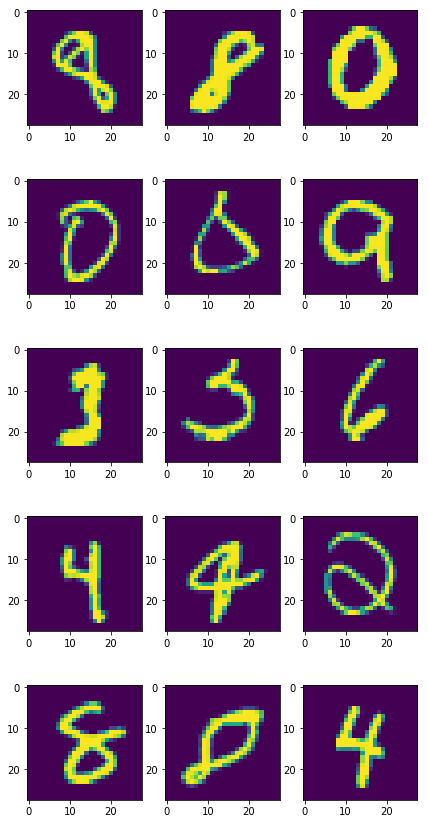

In [77]:
# Display the wrong examples
idx_wrong = np.logical_not(less)
idx_wrong = np.stack([idx_wrong]*3, axis = -1)
idx_wrong = np.reshape(idx_wrong, [-1])

wrong = triplets_test[idx_wrong]
wrong = np.squeeze(wrong)
print(len(wrong)//3)
s = 5
n = 5
e = n + s
plt.figure(figsize=(7,3*n))
for i in range(s,e):
    for j in range(3):
        plt.subplot(n,3,(i-s)*3+1+j)
        plt.imshow(wrong[i*3+j])

In [30]:
a = emb[0::3]
p = emb[1::3]
n = emb[2::3]

# Computes distance between pairs
dist1 = np.sum(np.square(a-p),1)
dist2 = np.sum(np.square(a-n),1)
less = np.less(dist1,dist2)
acc = np.sum(less.astype(int))/len(less)
print(acc)

0.6205


In [66]:
model.layers

In [78]:
mod = tf.keras.Model(model.inputs, model.layers[-2].output)
predict = mod.predict(x_train)

[[ -3.46599841  12.89652997]
 [  4.4826858  -13.52432727]
 [ 11.80554607  -9.21842322]
 [-21.84814866   0.54798124]
 [ 18.95008703  -0.95030526]
 [-10.29194869   8.05386218]
 [-11.56619133  -8.3117071 ]
 [  6.09481662  14.81631112]
 [ -3.51327994 -10.46853664]
 [  6.75712546   4.25543613]]
[65.55563664 66.50870237 72.06145722 88.73134652 82.40704833 65.28270348
 67.0560509  74.58631191 60.96426071 55.42522948]


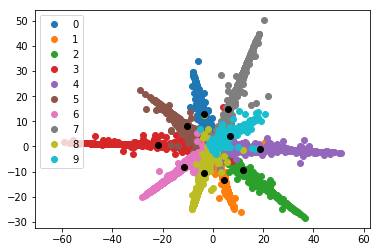

In [79]:
mean = np.zeros((10,2))
nb = np.zeros(10)
y_int = y_train
# y_train = y_train.astype(int)
# y_int = np.empty(len(y_train),dtype=int)
# for i in range(len(y_train)):
#     idx = 0
#     while (y_train[i][idx]!=1):
#         idx += 1
#     y_int[i] = int(idx)

for i in range(len(predict)):
    mean[y_int[i]] += predict[i]
    nb[y_int[i]] += 1

for i in range(len(mean)):
    mean[i] /= nb[i]
print(mean)

std_vect = np.zeros((10,2)) + mean
std = np.zeros(10)
for i in range(len(predict)):
    std[y_int[i]] += np.sum(np.square(predict[i]-mean))

for i in range(len(mean)):
    std[i] /= nb[i]
print(np.sqrt(std))

plt.axis('equal')
n = 10
for i in range(n):
    y = predict[np.equal(i,y_int)]
    #y = y / np.linalg.norm(y, axis=-1,keepdims=True)
    plt.plot(y[:,0],y[:,1],'o',label=str(i))
#mean = mean/np.linalg.norm(mean, axis=-1,keepdims=True)
plt.plot(mean[:n,0],mean[:n,1],'ko')
plt.legend()